In [1]:
import numpy as np

embeddings = np.array([
    [1, 0],
    [1.2, 0.1],
    [0, 1],
    [-1, 0.1],
    [-1.2, 0],
    [-1.4, 0.3],
    [0, -1]
])
names = ['Film1', 'Film2', 'Livre', 'Opéra1', 'Opéra2', 'Opéra3', 'Concert']

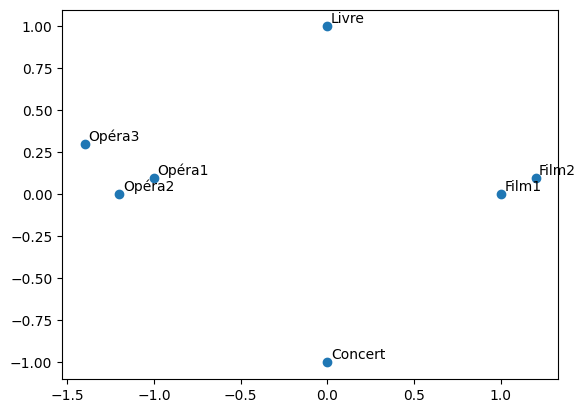

In [2]:
import matplotlib.pyplot as plt

plt.scatter(embeddings[:, 0], embeddings[:, 1])
for i, name in enumerate(names):
    plt.annotate(name, xy=embeddings[i], xytext=embeddings[i] + 0.02)

$$k(i, j) = q_i \phi_i^T \phi_j q_j$$
$$x_i = q_i \phi_i$$

$$R(x, a) = x^T a$$

Comment paramétriser les actions ? (one hot catégorie)

- Unifier ces notations (embedding, $q_i = p(B = 1)$ ?)
- Jouer avec du code DPP
- Reprendre des modèles simples de recommandation (régression linéaire ou logistique)

In [3]:
contexte = np.array([0, 1, 0, 1])
item = np.array([0, 1, 0, 0])
delta = contexte @ item
delta

1

In [4]:
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

X = embeddings
K_lin = linear_kernel(X)

import random

def sample(K):
    N, _ = K.shape
    lam, v = map(np.real, np.linalg.eig(K))
    V = v[:, [random.random() < lam[i] / (lam[i] + 1) for i in range(N)]]
    _, nb = V.shape
    selected = []
    while nb:
        V, _ = np.linalg.qr(V)
        proba = ((V ** 2) / nb).sum(axis=1)
        k = np.random.choice(N, p=proba)
        selected.append(k)
        removed_index = np.where(V[k, :] != 0)[0][0]
        remover = V[:, removed_index] / V[k, removed_index]
        V = V - np.outer(remover, V[k, :])
        V = np.delete(V, removed_index, axis=1)
        nb -= 1
    return selected

sample(K_lin)

[6, 4]

In [5]:
K_lin

array([[ 1.  ,  1.2 ,  0.  , -1.  , -1.2 , -1.4 ,  0.  ],
       [ 1.2 ,  1.45,  0.1 , -1.19, -1.44, -1.65, -0.1 ],
       [ 0.  ,  0.1 ,  1.  ,  0.1 ,  0.  ,  0.3 , -1.  ],
       [-1.  , -1.19,  0.1 ,  1.01,  1.2 ,  1.43, -0.1 ],
       [-1.2 , -1.44,  0.  ,  1.2 ,  1.44,  1.68,  0.  ],
       [-1.4 , -1.65,  0.3 ,  1.43,  1.68,  2.05, -0.3 ],
       [ 0.  , -0.1 , -1.  , -0.1 ,  0.  , -0.3 ,  1.  ]])

In [6]:
def esym_poly(k, lam):
  N = lam.size
  E = np.zeros((k+1, N+1))
  E[0, :] = np.ones((1, N+1))
  for l in range(1, k+1):
    for n in range(1, N+1):
      E[l, n] = E[l, n-1] + lam[n-1]*E[l-1, n-1]

  return E


def sample_k(k, lam, V_full):
  E = esym_poly(k, lam)
  J = []
  remaining = k-1
  i = lam.size-1

  while remaining>=0:
    marg = 0.0
    if i == remaining:
      marg = 1.0
    else:
      if E[remaining+1, i+1] == 0:
        i = i-1
        continue
      marg = lam[i]*E[remaining, i]/E[remaining+1, i+1]

    if np.random.rand() < marg:
      J.append(i)
      remaining = remaining-1
    
    i = i-1

  k = len(J)-1
  Y = np.zeros((len(J), 1))
  V = V_full[:, J]

  for i in range(k, -1, -1):
    # Sample
    Pr = np.sum(V**2, axis=1)
    Pr = Pr/sum(Pr)
    C = np.cumsum(Pr)
    jj = np.argwhere(np.random.rand() <= C)[0]
    Y[i] = jj

    # Update V 
    j = np.argwhere(V[int(Y[i]), :])[0]
    Vj = V[:, j]
    V = np.delete(V, j, 1)
    V = V - np.outer(Vj, V[int(Y[i]), :]/Vj[int(Y[i])])

    # QR decomposition, which is more numerically stable (and faster) than Gram
    # Schmidt
    if i > 0:
      V, r = np.linalg.qr(V)

  return Y

In [68]:
from sklearn.gaussian_process.kernels import DotProduct, RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

kernel = DotProduct(1.0, (1e-3, 1e3))
kernel = RBF(1., (1e-5, 1e5))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)


class MangakiDPP:
    def __init__(self, work_ids=None, vectors=None):
        self.work_ids = np.array(work_ids)
        self.vectors = vectors

    def compute_similarity(self):
        # self.L = self.vectors.dot(self.vectors.T)
        self.L = kernel(self.vectors)

    def preprocess(self, indices=None):
        self.compute_similarity()
        if indices is None:
            indices = list(range(len(self.vectors)))
        D, V = np.linalg.eig(self.L[np.ix_(indices, indices)])
        self.D = np.real(D)
        self.V = np.real(V)

    def sample_k(self, k):
        sampled_indices = [int(index) for index in sample_k(k, self.D, self.V)]
        return self.work_ids[sampled_indices]

In [74]:
dpp = MangakiDPP(range(len(embeddings)), embeddings)
dpp.preprocess()

item_ids = dpp.sample_k(3)
for item_id in item_ids:
    print(item_id, names[item_id])

2 Livre
4 Opéra2
0 Film1


In [75]:
# !pip install git+https://github.com/mangaki/mangaki

In [76]:
# sample_k(K_lin)

In [77]:
embeddings[history[:, 0]]

array([[1., 0.],
       [0., 1.]])

Bayesian optimization (~ Thompson sampling) https://www.miguelgondu.com/blogposts/2023-07-31/intro-to-bo/

In [80]:

history = np.array([
    [0, 1],  # Likes Film1
    [2, 1],  # Dislikes Livre
    #[3, 1]  # Likes Opera
])  # Feedback implicite

gp.fit(embeddings[history[:, 0]], history[:, 1])
y_pred, y_std = gp.predict(embeddings, return_std=True)

In [81]:
EPSILON = 2

for i, (item, pred, std) in enumerate(zip(names, y_pred, y_std)):
    print(i, item, 'pred', pred.round(5), 'std', std.round(5), ((1 + pred) * std).round(5))#, (pred + EPSILON * std).round(5))

0 Film1 pred 0.99502 std 0.07053 0.14072
1 Film2 pred 0.99502 std 0.07053 0.14072
2 Livre pred 0.99502 std 0.07053 0.14072
3 Opéra1 pred 0.99502 std 0.07054 0.14072
4 Opéra2 pred 0.99502 std 0.07054 0.14072
5 Opéra3 pred 0.99502 std 0.07054 0.14072
6 Concert pred 0.99502 std 0.07054 0.14072


- $p(B = 1) \Delta$
- $(1 + p(B = 1)) \Delta$
- $p(B = 1) (1 + \Delta) \textrm{ (simplified : entre 0 et 2)}$
- $(1 + p(B = 1)) (1 + \Delta)$
- $p(C = 1) + p(B = 1) (1 + \Delta) \textrm{ (current : entre 0 et 7)}$
- $\left(p(C = 1) + p(B = 1)\right) (1 + \Delta)$
- $p(C = 1) + p(B = 1) \frac{(1 + \Delta)}6$

- [x] Embeddings (norme 1) DPP
- [x] Bookings
- [ ] Delta

/!\ Les Delta dépendent des Delta précédents => samples non iid  
Définir les Delta (déterministes) au moment de construction du noyau DPP

Avoir un modèle du comportement (Clic < Favori < Booking)

Favoriser/pénaliser l'échantillonnage en fonction de $p(B = 1) * \Delta$ ? Ou de l'incertitude ?

Ajouter du poids là où la masse de proba est faible

In [137]:
# TwoTowers: pas de temporalité
# QPI: questionnaire pratique initiale (déjà fait ; ce que tu aimes ou pas)